# Bayes analysis of SIR model with changing points

## Libraries

In [1]:
# load libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma as gamma_func

from utils import *
from mcmc import *
from clustering import *
from regional_data_extractor import *


/home/vepe/miniconda3/envs/torch/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Veneto data 

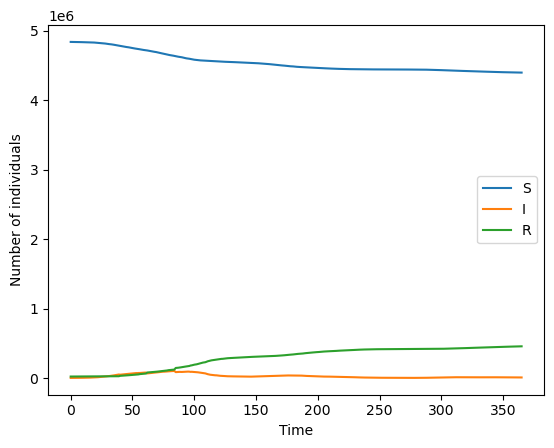

In [2]:
#load the Italian covid data
italian_data = pd.read_excel('ItalianData.xlsx')

#select the region of interest and the starting and ending date
sir_data = sir_data_extractor(italian_data, region='Veneto', start_date='2020-10-1', end_date='2021-10-1')

#crate the dataframw with the right variables for the SIR model
sir_dataframe = create_SIR_dataframe(sir_data)

#exctract the data into numpy array
S = sir_dataframe['S'].values
I = sir_dataframe['I'].values
R = sir_dataframe['R'].values
T = len(sir_dataframe)-1

plt.plot(S, label='S')
plt.plot(I, label='I')
plt.plot(R, label='R')
plt.xlabel('Time')
plt.ylabel('Number of individuals')
plt.legend()


## MCMC algorithm

### Data preparation

In [3]:
#Save initial conditions
S_0 = S[0]
I_0 = I[0]
R_0 = R[0]
N_0 = S_0 + I_0 + R_0
P_0 = I_0 / N_0

In [4]:
S = S[1:]
R = R[1:]
I = I[1:]

P = I / N_0

In [5]:
delta_R = R[1:] - R[:-1]
delta_R = np.concatenate([[R[0] - R_0], delta_R])

delta_I = S[:-1] - S[1:]
delta_I = np.concatenate([[S_0 - S[0]], delta_I])

print("Modified length: ", R.shape)
print("T: ", T)

Modified length:  (365,)
T:  365


### MCMC hyper-parameter

In [6]:
N = 15_000  # n samplings
burnin = 5000
thinning = 10
p = 0.01

### Algorithm parameters

In [7]:
betas = np.zeros([N, T])
gammas = np.zeros([N, T])
bs = np.zeros([N, T])
rs = np.zeros([N, T])
deltas = np.zeros([N, T])

In [8]:
# init
delta_0 = np.random.binomial(1, p, size=T) 
delta_0[0] = 1
K_0 = np.sum(delta_0) # Number of Changeing points
eta_0 = np.cumsum(delta_0) #Number of Changing points up to time t

# vectors of K elements
r_0 = np.random.gamma(shape=0.1, scale=10, size=K_0)
b_0 = np.random.gamma(shape=0.1, scale=10, size=K_0)

r_0 = r_0[eta_0-1]
b_0 = b_0[eta_0-1]

beta_0 = np.random.exponential(1/b_0)
gamma_0 = np.random.beta(r_0, 1)

In [9]:
delta = delta_0.copy()
beta = beta_0.copy()
gamma = gamma_0.copy()
r = r_0.copy()
b = b_0.copy()

### Simulation

In [10]:
from tqdm.notebook import tqdm

In [11]:
K = np.sum(delta)
eta = np.cumsum(delta)
for n in tqdm(range(N)):

    delta_ = propose_delta(delta, T)
    delta = accept_delta(delta, delta_, beta, gamma, T, p)

    b = update_b(delta, beta)
    r = update_r(delta, gamma)

    beta = update_beta(delta, T, S_0, P_0, S, P, delta_I)
    gamma = update_gamma(r, T, I_0, I, delta_R)

    betas[n, :] = beta
    gammas[n, :] = gamma
    deltas[n, :] = delta
    rs[n, :] = r
    bs[n, :] = b

  0%|          | 0/15000 [00:00<?, ?it/s]

/home/vepe/uni/Information_Theory/bayesian-sir-with-changing-points/mcmc.py:95: RuntimeWarning: invalid value encountered in scalar subtract
  likelihood_ratio = log_likelihood(delta_candidate, beta, gamma) - log_likelihood(delta_original, beta, gamma)


## Analysis of data

In [29]:
beta_samples = betas[burnin::thinning, :]
delta_samples = deltas[burnin::thinning, :]
b_samples = bs[burnin::thinning, :]
r_samples = rs[burnin::thinning, :]
gamma_samples = gammas[burnin::thinning, :]
eta_samples = np.cumsum(delta_samples, axis=1)

n_samples = eta_samples.shape[0]
q = np.zeros((T, T))
for n in range(n_samples):
    q += (eta_samples[n, :] == (eta_samples[n, :])[:, None]).astype(int)
q = q / n_samples

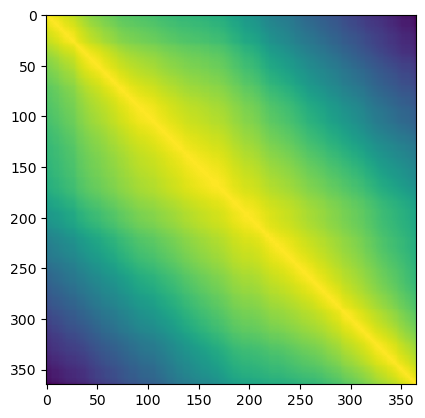

In [30]:
import matplotlib.colors as col
plt.imshow(q, norm = 'log')


### Clustering

In [31]:
delta_hat = np.array([0] * T)
delta_hat[0] = 1


eta_hat = np.cumsum(delta_hat)

continue_add = True
continue_swap = True

In [32]:
delta_final = clustering(delta_hat, eta_hat, q, T, continue_add, continue_swap)

### Changing points 

In [33]:
eta_final= np.cumsum(delta_final)
K_final= np.sum(delta_final)

tau_final= np.where(delta_final==1)[0]

In [34]:
tau_final

array([  0, 211])

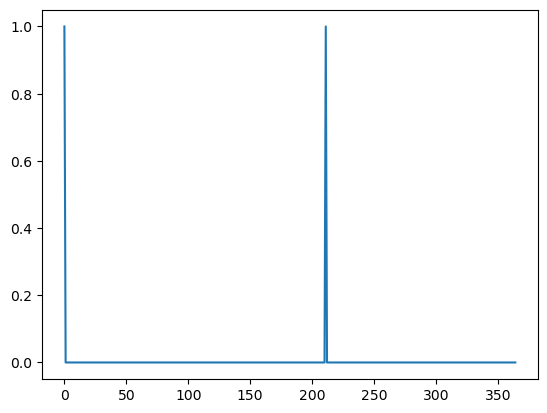

In [35]:
plt.plot(delta_final)


### Confidence intervals

In [36]:
alpha=0.05

In [37]:
def constraint_lhs(deltas, tau_l, tau_u):
    n_samples = deltas.shape[0]
    sum_tau = np.sum(deltas[:, tau_l:tau_u]) / n_samples
    return sum_tau

In [38]:
def possible_taus(tau_k, delta_tau):
    lower= tau_k
    upper= tau_k +delta_tau
    possible=[]
    for i in range(delta_tau+1):
        if upper<=T and lower>=0:
            possible.append((lower, upper))
            lower-=1
            upper-=1
    return possible

# possible_taus(4, 4)

In [39]:
ci_tau = []
for tau_k in tau_final:
    for delta_tau in range(2, T):
        candidate = []
        possible_taus_list = possible_taus(tau_k, delta_tau)
        for tau_l, tau_u in possible_taus_list:
            sum_tau = constraint_lhs(delta_samples, tau_l, tau_u)
            if sum_tau >= 1 - alpha:
                candidate.append([sum_tau, tau_l, tau_u])
        if len(candidate) > 0:
            break

    if len(candidate) == 0:
        ci_tau.append(np.array([0, T]))
    else:
        candidate = np.array(candidate)
        index_max_candidate = np.argmax(candidate[:, 0])
        ci_tau.append(candidate[index_max_candidate, 1:])

### Final Beta and Gamma

In [40]:
sum_beta = np.zeros(T)
sum_gamma = np.zeros(T)
n_smaples_reduced = delta_samples.shape[0]
for g in range(n_smaples_reduced):
    sum_beta += 1 / b_samples[g, :]
    sum_gamma+= r_samples[g, :]/(1+r_samples[g, :])
beta_final = sum_beta / n_smaples_reduced
gamma_final = sum_gamma / n_smaples_reduced

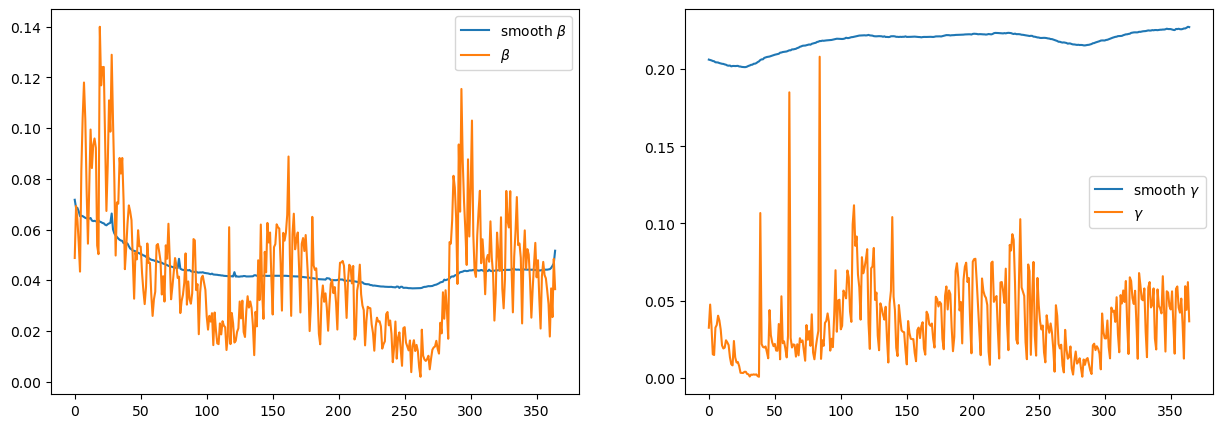

In [44]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(121)
ax.plot(beta_final, label=r'smooth $\beta$')
ax.plot(np.mean(beta_samples, axis=0), label=r'$\beta$')
ax.legend()

ax = fig.add_subplot(122)
ax.plot(gamma_final, label=r'smooth $\gamma$')
ax.plot(np.mean(gamma_samples, axis=0), label=r'$\gamma$')
ax.legend()

## Bayesian analysis     

#### Plots

In [27]:
posterior_frequency = np.sum(delta_samples[:, 1:], axis = 0)/n_samples

Text(0.5, 0, 'Time[Days]')

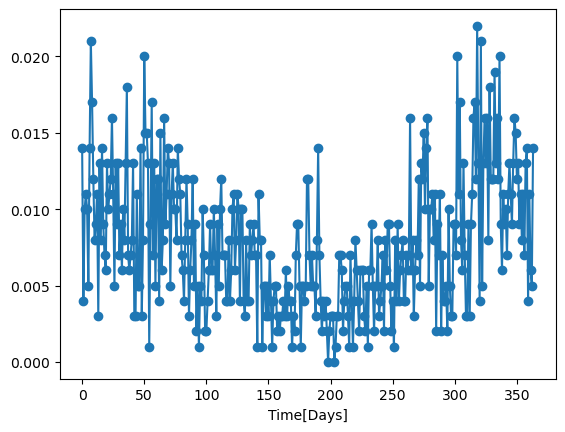

In [28]:
plt.plot(posterior_frequency, 'o-')
# for gt in gt_changing_points[1:]:
#     plt.axvline(gt, linestyle = '--', c = 'k')

plt.xlabel('Time[Days]')

#### Changing Points

In [29]:
K_final = np.sum(delta_final)

In [30]:
tau_final

array([  0, 183])

In [31]:
ci_tau

[array([0., 2.]), array([ 50., 185.])]

### Metrics

#### ARI

In [32]:
TP = 0
FP = 0
FN = 0
TN = 0
for i in range(T):
    for j in range(i+1, T):
        TP = TP + int(eta_final[i]==eta_final[j] and gt_eta[i]==gt_eta[j])
        FP = FP + int(eta_final[i]!=eta_final[j] and gt_eta[i]==gt_eta[j])
        FN = FN + int(eta_final[i]==eta_final[j] and gt_eta[i]!=gt_eta[j])
        TN = TN + int(eta_final[i]!=eta_final[j] and gt_eta[i]!=gt_eta[j])

TP = TP*2/(T*(T-1))
FP = FP*2/(T*(T-1))
FN = FN*2/(T*(T-1))
TN = TN*2/(T*(T-1))

NameError: name 'gt_eta' is not defined

In [ ]:
ARI = (TP + TN - ((TP+FP)*(TP+FN)+(TN+FP)*(TN+FN)))/(1-((TP+FP)*(TP+FN) + (TN+FP)*(TN+FN)))
print('ARI:', ARI)

ARI: 0.0


#### Mutual information  (NON sono definiti k1 e k2)

In [ ]:
MI = 0


for k1 in range(int(K_final)):
    for k2 in range(int(K_final)):
        n_k1 = np.sum(gt_eta == k1)
        n_k2 = np.sum(eta_final == k2)
        n_k1k2 = np.sum((gt_eta == k1) & (eta_final == k2))
        if n_k1k2 > 0:
            MI += n_k1k2/T * (np.log(T * n_k1k2) - np.log(n_k1 * n_k2))

NameError: name 'gt_eta' is not defined

In [ ]:
print('MI:', MI)

MI: 0
